In [2]:
!pip install yfinance
!pip install mpld3

     |████████████████████████████████| 6.4 MB 7.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 201 kB 5.4 MB/s 


In [ ]:
from plotly import __version__
!pip install chart_studio
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

cf.go_offline()

## Stock DATASET

In [3]:
from torch.utils.data import Dataset, DataLoader
from typing import Union
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
import torch
from torch.nn import MSELoss
from torch.optim import RMSprop
import yfinance as yf
import pandas as pd
import numpy as np
import os
import math


In [4]:
class StockPriceDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, transform=None,
                 file_dir: str="data/", csv_file: str=None):

        # If a local data file must be loaded:
        if csv_file is not None:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                dataset = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)

        self.data = dataset
        self.nb_samples = nb_samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data) - self.nb_samples

    def __getitem__(self, index, overlapping=True) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        if overlapping:
          sample = self.data['Close'][index:index+self.nb_samples+2]
        else:
          sample = self.data['Close'][index*self.nb_samples:(index+1)*self.nb_samples+2]
        sample = torch.tensor(sample)
        if self.transform:
            sample = self.transform(sample)[1:]
        else:
            sample = sample[1:]
        
        label = sample[-1] # label is the last elem of sample
        sample = sample[:-1] # removes label from sample
        return sample, label
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.data['Close'][index]


def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

[*********************100%***********************]  1 of 1 completed
head of the dataset = Date
1950-01-03    16.66
1950-01-04    16.85
1950-01-05    16.93
1950-01-06    16.98
1950-01-09    17.08
Name: Close, dtype: float64

 Plot of the 'Close' data :
len dataset = 14799


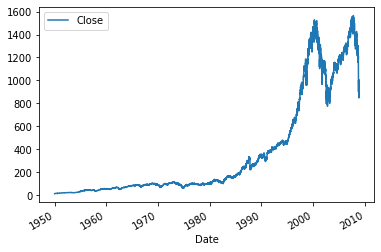

In [5]:
VISUALIZE_DATASET = True
if VISUALIZE_DATASET:
  dataset = StockPriceDataset(start_date='1950-01-03', 
                              end_date='2008-11-16',
                              interval='1d',
                              nb_samples=15,
                              transform=normalize_by_last_unknown_price)

  print("head of the dataset =", dataset.data.head()['Close'])

  print("\n Plot of the 'Close' data :")
  dataset.data.plot(None, ['Close'])

  print("len dataset =", len(dataset))

## Modèle

In [6]:
from torch.nn import LSTM, Module, Dropout, ModuleList

In [7]:
class StockAI(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, keep_prob) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers,dropout=1-keep_prob, batch_first=True,  proj_size=1)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]
    

## Configuration

In [8]:
class StockAIConfig():
    config = {
        "model":{
            "input_size": 1,
            "lstm_size": 128,
            "num_layers": 1,
            "keep_prob": 0.8
        },

        "dataset_train":{
            "start_date": '1950-01-03',
            "end_date": '2008-11-16',
            "interval_date": '1d',
            "nb_samples":15,
            "batch_size": 64,
            "shuffle":False
        },
        "dataset_test":{
            "start_date": '2008-11-17',
            "end_date": '2021-11-16',
            "interval_date": '1d',
            "nb_samples":15,
            "batch_size": 64,
            "shuffle":False
        },

        "learning":{
            "num_steps": 30,
            "init_lr": 1e-03,
            "lr_decay": 0.99,
            "init_epoch": 5,
            "max_epoch": 50
        }   
    }

##Prediction : Train / Test

In [9]:
# Model config
config = StockAIConfig().config

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init of the Dataset_train
dataset_train = StockPriceDataset(config["dataset_train"]["start_date"], 
                            config["dataset_train"]["end_date"],
                            config["dataset_train"]["interval_date"], 
                            config["dataset_train"]["nb_samples"],
                            transform=normalize_by_last_unknown_price)

# Init dataloader of the Dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)

# Init of the Dataset_test
dataset_test = StockPriceDataset(config["dataset_test"]["start_date"], 
                            config["dataset_test"]["end_date"],
                            config["dataset_test"]["interval_date"], 
                            config["dataset_test"]["nb_samples"],
                            transform=normalize_by_last_unknown_price)

# Init dataloader of Dataset_test
dataloader_test = DataLoader(dataset_test, config["dataset_test"]["batch_size"], config["dataset_test"]["shuffle"], drop_last=True)

# Init of the model
model = StockAI(config["model"]["input_size"],
                config["model"]["lstm_size"],
                config["model"]["num_layers"],
                config["model"]["keep_prob"])

model.to(device)

# Learning rate to use along the epochs
learning_rates = [config["learning"]["init_lr"] * (config["learning"]["lr_decay"] ** max(float(i + 1 - config["learning"]["init_epoch"]), 0.0)) for i in range(config["learning"]["max_epoch"])]

# Loss
loss_fn = MSELoss()
optimizer = RMSprop(model.parameters(), lr=learning_rates[0], eps=1e-08)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19999999999999996 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [10]:
len(dataloader_train)

231

In [11]:
# Learning
for epoch_step in range(config["learning"]["max_epoch"]):
    lr = learning_rates[epoch_step]
    print(f"Running for epoch {epoch_step}...")
    for i_batch, batch in enumerate(dataloader_train):
        x, y = batch
        x = torch.unsqueeze(x, -1).float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = torch.squeeze(model.forward(x))
        loss = loss_fn(y_pred, y)

        if i_batch%100==0:
            print(f"step: {i_batch}, loss = {loss}")

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Running for epoch 0...
step: 0, loss = 1.026247262954712
step: 100, loss = 0.0011268997332081199
step: 200, loss = 0.0009142333874478936
Running for epoch 1...
step: 0, loss = 0.0030833075288683176
step: 100, loss = 0.0016467085806652904
step: 200, loss = 0.0008523390861228108
Running for epoch 2...
step: 0, loss = 0.002856544917449355
step: 100, loss = 0.0015245890244841576
step: 200, loss = 0.0007932614535093307
Running for epoch 3...
step: 0, loss = 0.002642824547365308
step: 100, loss = 0.0014110133051872253
step: 200, loss = 0.0007375415880233049
Running for epoch 4...
step: 0, loss = 0.002431037835776806
step: 100, loss = 0.0013205046998336911
step: 200, loss = 0.0006861642468720675
Running for epoch 5...
step: 0, loss = 0.0022246118169277906
step: 100, loss = 0.0012423554435372353
step: 200, loss = 0.0006400423590093851
Running for epoch 6...
step: 0, loss = 0.0020320951007306576
step: 100, loss = 0.0011779307387769222
step: 200, loss = 0.0005998525302857161
Running for epoch 7.

In [12]:
#test
runnning_mape = 0
for i_batch, batch in enumerate(dataloader_test):
        x, y = batch
        x = torch.unsqueeze(x, -1).float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x)
        error = torch.mean(torch.abs((y - y_pred) / y))
        runnning_mape += error

mape = runnning_mape / len(dataloader_test)
print("",mape)

 tensor(0.0347, device='cuda:0', grad_fn=<DivBackward0>)


In [14]:
# Predict one following sample, taking the nb_samples last real values of S&P500
nb_test = len(dataset_test)
print("longueur du dataset test = ", nb_test)
y_truth = []
y_hat = []
for i in range(nb_test):
  x, y = dataset_test.__getitem__(i)
  norm_value = dataset_test.get_normalization_value(i)
  x = torch.unsqueeze(torch.unsqueeze(x, 0), -1).float()
  x = x.to(device)
  y_pred = model.forward(x)
  y_truth.append(torch.Tensor.cpu(y).detach().numpy()*norm_value)
  y_hat.append(float(torch.Tensor.cpu(y_pred).detach().numpy())*norm_value)

df = pd.DataFrame({
    "sample_id":np.arange(len(dataset_test)),
    "real_value":y_truth,
    "predicted_value":y_hat
    })

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-2.4.2.min.js?noext',
            },
          });
        </script>
        '''))

configure_plotly_browser_state()
df.iplot(kind='line', x='sample_id', y=['real_value','predicted_value'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data')
plt.show()

longueur du dataset test =  3257


In [15]:
# # Predict one following sample, taking the nb_samples last real values or lastly predicted values of S&P500
nb_test = len(dataset_test)
nb_samples = config["dataset_test"]["nb_samples"]
print("longueur du dataset test = ", nb_test)
y_truth = []
y_hat = []
x, y = dataset_test.__getitem__(0)
x, y = x.to(device), y.to(device)

for i in range(nb_test):

  _, y = dataset_test.__getitem__(i)

  # Normalization value for the current batch, needed to reproduce real value
  norm_value = dataset_test.get_normalization_value(i)
  x = torch.unsqueeze(torch.unsqueeze(x, 0), -1).float()
  x = x.to(device)

  # model computations + prediction
  y_pred = model.forward(x)

  # Ajout du y_pred à la fin du tenseur x et retrait de sa première valeur pour incrémenter d'une période temporelle
  x = torch.cat((torch.squeeze(x)[1:nb_samples], y_pred.reshape(1)))

  y_truth.append(torch.Tensor.cpu(y).detach().numpy()*norm_value)
  y_hat.append(float(torch.Tensor.cpu(y_pred).detach().numpy())*norm_value)

df = pd.DataFrame({
    "sample_id":np.arange(len(dataset_test)),
    "real_value":y_truth,
    "predicted_value":y_hat
    })

configure_plotly_browser_state()
df.iplot(kind='line', x='sample_id', y=['real_value','predicted_value'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data')
plt.show()

longueur du dataset test =  3257
